<a href="https://colab.research.google.com/github/Dharmasastha2005/CRC-NSCLC-Gene-Profiling/blob/main/Genomic_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Basic Entry Level Analysis and Data Loading

NSCLC subset shape: (57736, 74)
Number of NSCLC samples: 20
Number of Healthy samples: 54


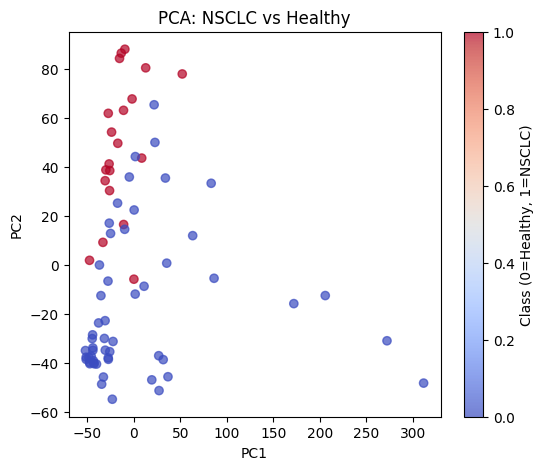

ROC AUC: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        54
           1       1.00      1.00      1.00        20

    accuracy                           1.00        74
   macro avg       1.00      1.00      1.00        74
weighted avg       1.00      1.00      1.00        74



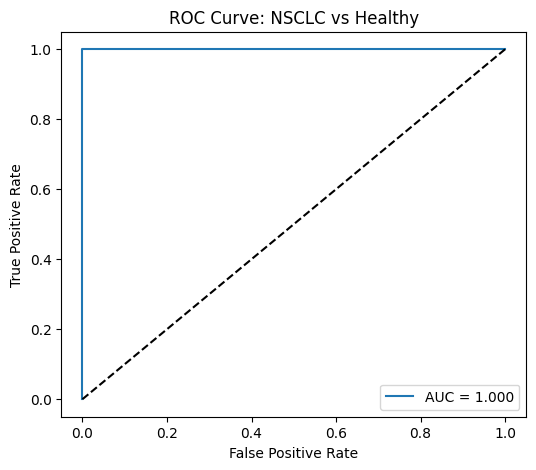

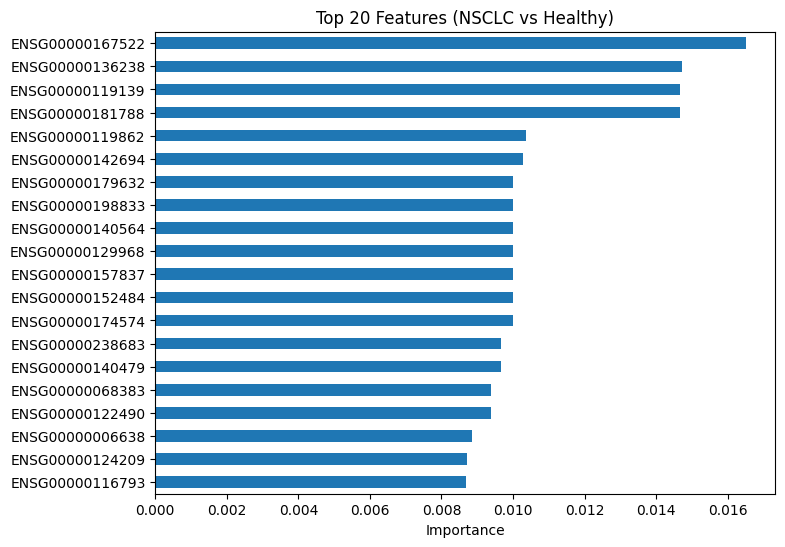

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, classification_report

# Load dataset (if not already loaded)
data = pd.read_csv("/content/GSE68086_TEP_data_matrix.csv", index_col=0)

# Identify NSCLC and healthy samples
nsclc_cols = [c for c in data.columns if "NSCLC" in c.upper()]
healthy_cols = [c for c in data.columns if "HD" in c.upper() or "CONTROL" in c.upper()]

# Subset for NSCLC analysis
nsclc_df = data[nsclc_cols + healthy_cols].dropna()
print("NSCLC subset shape:", nsclc_df.shape)

# Transpose so samples are rows, features are columns
X = nsclc_df.T

# Binary labels: 1 = NSCLC, 0 = Healthy
y = np.array([1 if "NSCLC" in c.upper() else 0 for c in nsclc_df.columns])

print("Number of NSCLC samples:", sum(y))
print("Number of Healthy samples:", len(y) - sum(y))

# Scale features
X_scaled = StandardScaler().fit_transform(X)

# PCA for 2D visualization
pca = PCA(n_components=2)
coords = pca.fit_transform(X_scaled)

plt.figure(figsize=(6, 5))
plt.scatter(coords[:, 0], coords[:, 1], c=y, cmap="coolwarm", alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA: NSCLC vs Healthy")
plt.colorbar(label="Class (0=Healthy, 1=NSCLC)")
plt.show()

# Random Forest Classifier
clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(X_scaled, y)

# Predictions and evaluation
probs = clf.predict_proba(X_scaled)[:, 1]
preds = clf.predict(X_scaled)

auc = roc_auc_score(y, probs)
print("ROC AUC:", round(auc, 3))
print("\nClassification Report:\n", classification_report(y, preds))

# ROC curve visualization
fpr, tpr, _ = roc_curve(y, probs)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: NSCLC vs Healthy")
plt.legend()
plt.show()

# Get feature importances
importances = pd.Series(clf.feature_importances_, index=nsclc_df.index)
top_features = importances.sort_values(ascending=False).head(20)

plt.figure(figsize=(8, 6))
top_features.plot(kind="barh")
plt.xlabel("Importance")
plt.title("Top 20 Features (NSCLC vs Healthy)")
plt.gca().invert_yaxis()
plt.show()


CRC Genomics Data Analysis

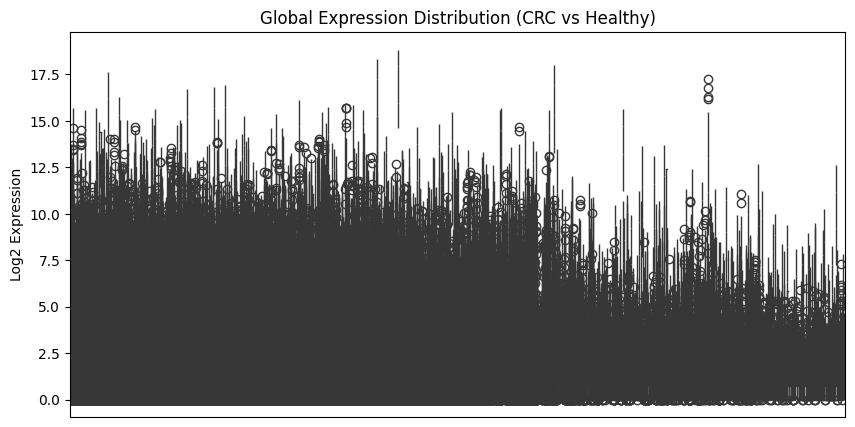

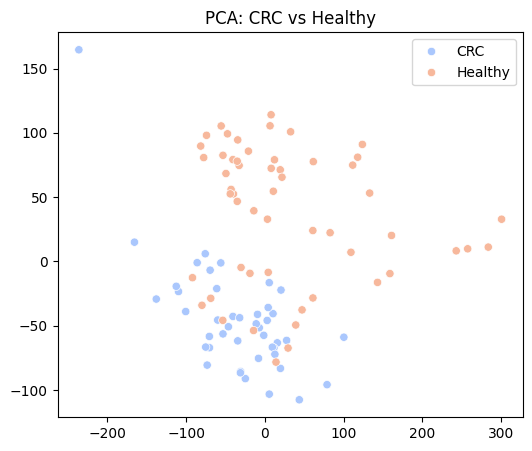

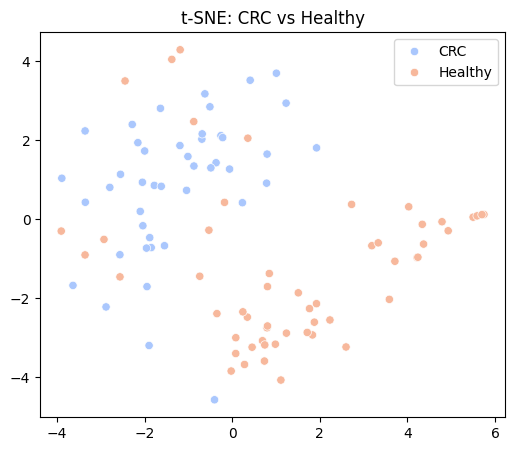

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


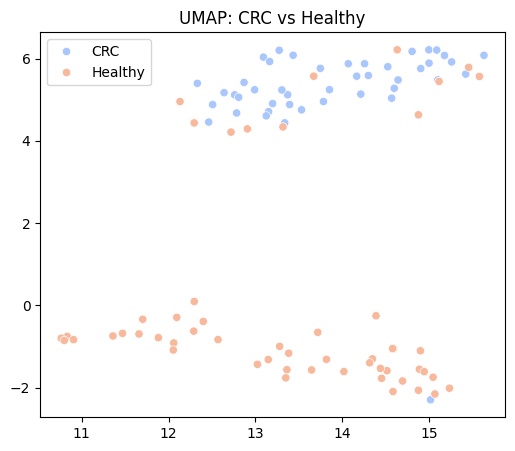

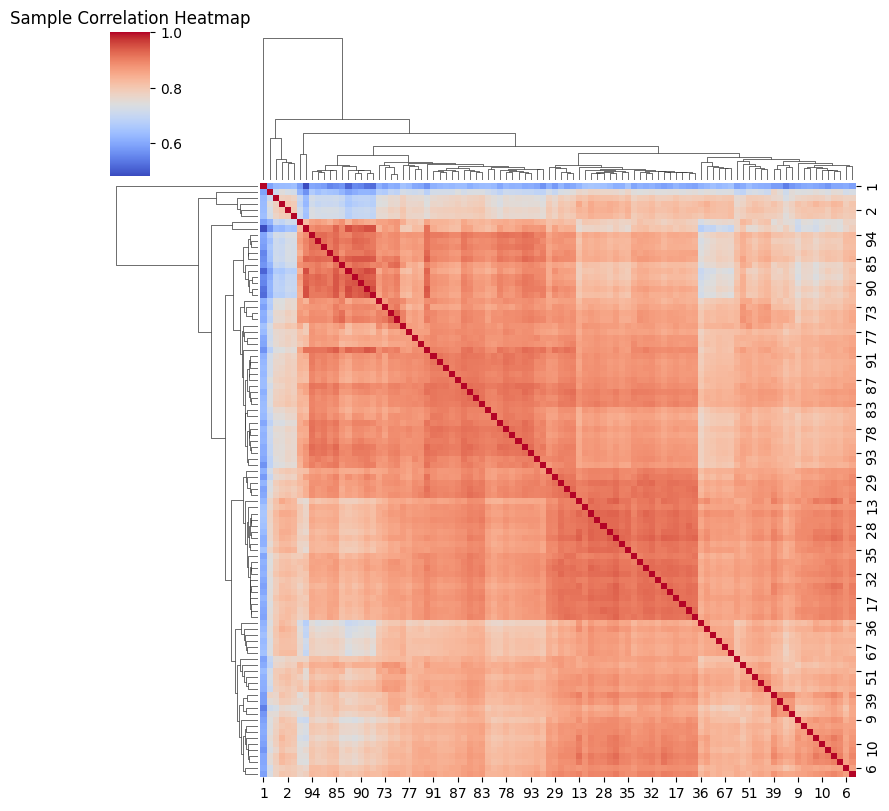

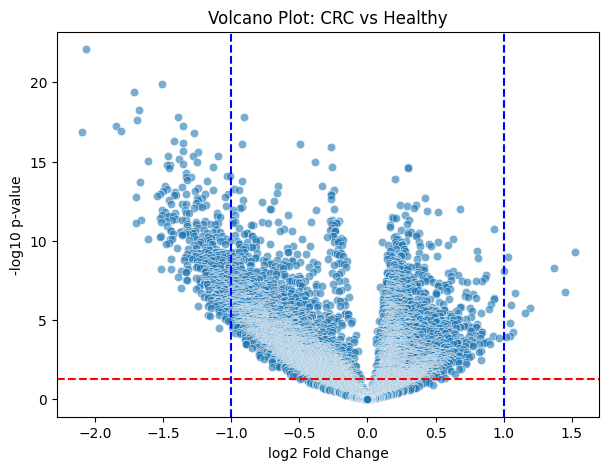

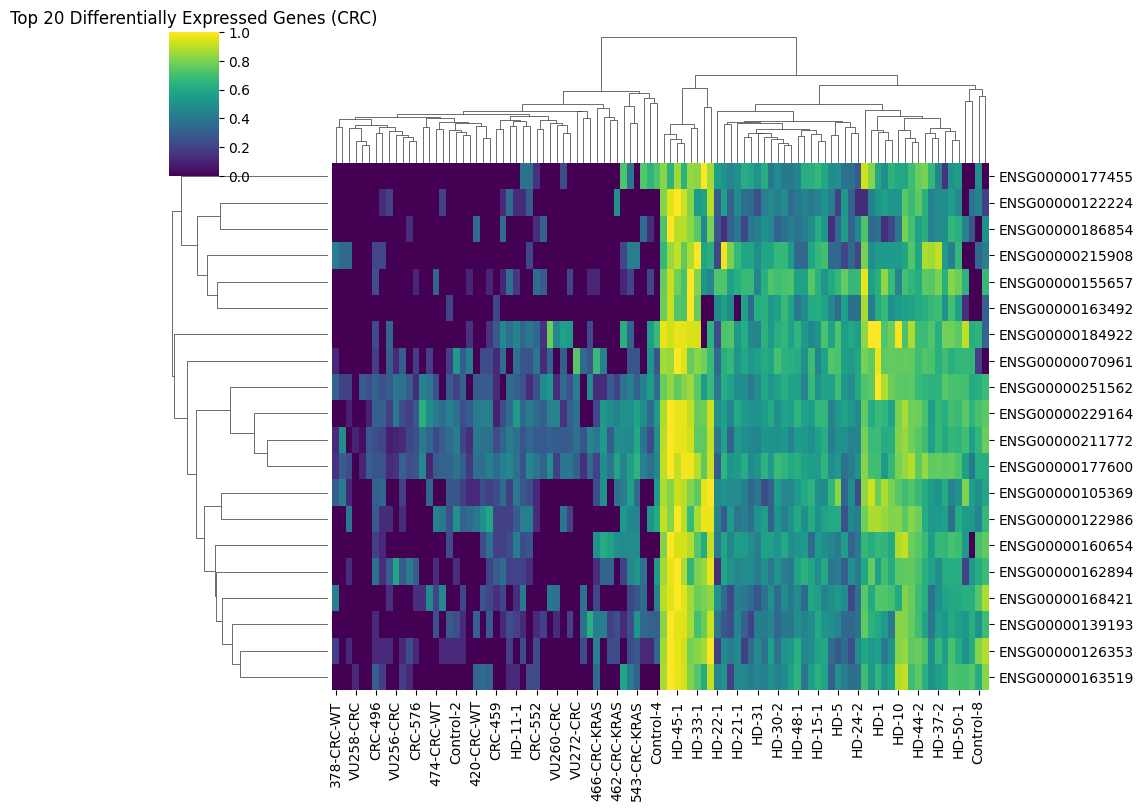

/tmp/ipython-input-3380235608.py:130: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Group", y="Expression", data=df, palette="coolwarm")


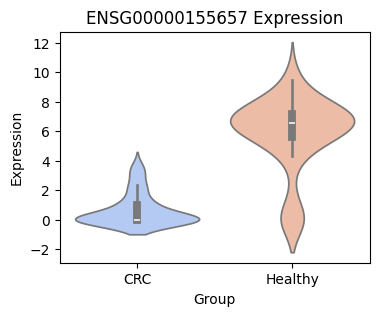

/tmp/ipython-input-3380235608.py:130: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Group", y="Expression", data=df, palette="coolwarm")


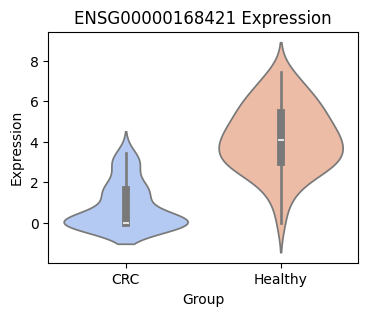

/tmp/ipython-input-3380235608.py:130: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Group", y="Expression", data=df, palette="coolwarm")


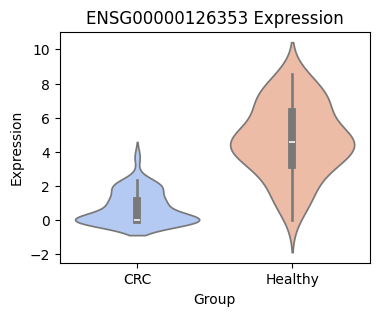

/tmp/ipython-input-3380235608.py:130: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Group", y="Expression", data=df, palette="coolwarm")


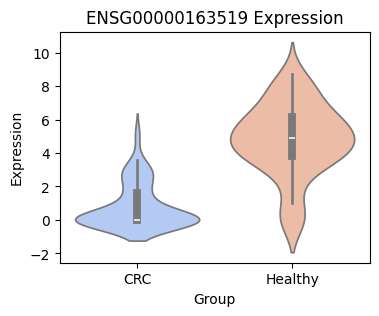

/tmp/ipython-input-3380235608.py:130: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Group", y="Expression", data=df, palette="coolwarm")


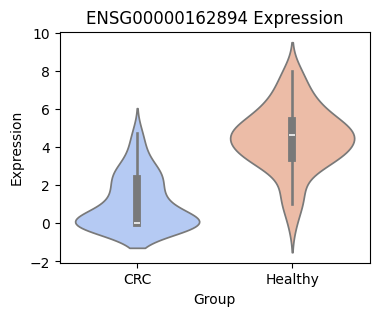

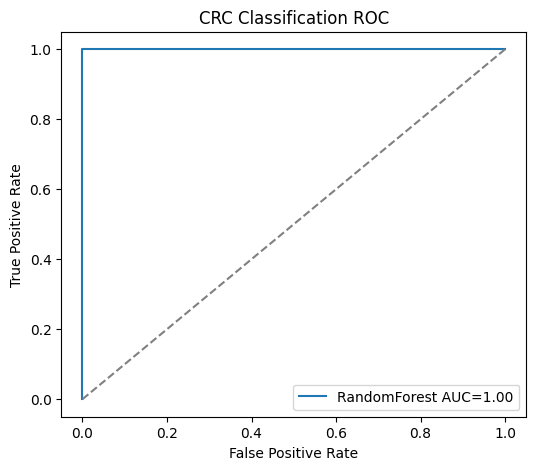

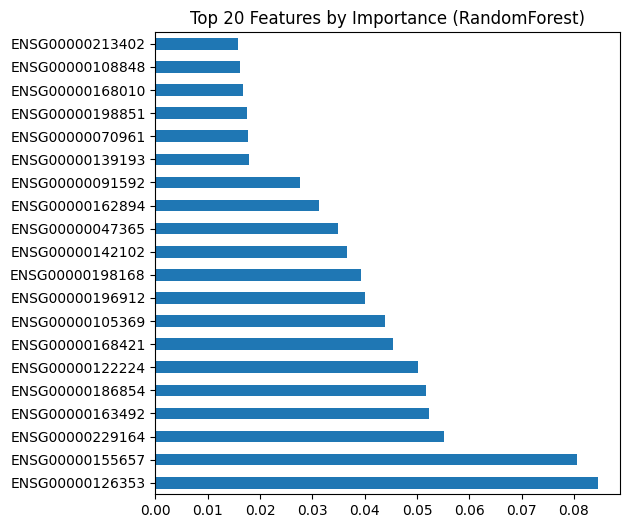

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from xgboost import XGBClassifier

# ---------------------------
# 1. Data Pre-Processing & QC
# ---------------------------

# Load expression matrix (rows=genes, cols=samples)
# Replace with your file path
data = pd.read_csv("/content/GSE68086_TEP_data_matrix.csv", index_col=0)

# Identify CRC and Healthy sample columns
crc_cols = [c for c in data.columns if "CRC" in c.upper()]
healthy_cols = [c for c in data.columns if "HD" in c.upper() or "CONTROL" in c.upper()]
subset = data[crc_cols + healthy_cols].dropna()

# Log2 transform if needed
subset = np.log2(subset + 1)

# Filter low-variance genes (keep top 50%)
gene_var = subset.var(axis=1)
subset = subset.loc[gene_var > np.percentile(gene_var, 50)]

# Labels
y = np.array([1 if "CRC" in c.upper() else 0 for c in subset.columns])
labels = ["Healthy" if i==0 else "CRC" for i in y]

# ---------------------------
# 2. Exploratory Data Analysis
# ---------------------------

# Boxplot of expression distribution
plt.figure(figsize=(10,5))
sns.boxplot(data=subset.T, palette="coolwarm")
plt.xticks([], [])
plt.ylabel("Log2 Expression")
plt.title("Global Expression Distribution (CRC vs Healthy)")
plt.show()

# PCA
pca = PCA(n_components=2)
pca_res = pca.fit_transform(subset.T)
plt.figure(figsize=(6,5))
sns.scatterplot(x=pca_res[:,0], y=pca_res[:,1], hue=labels, palette="coolwarm")
plt.title("PCA: CRC vs Healthy")
plt.show()

# t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_res = tsne.fit_transform(subset.T)
plt.figure(figsize=(6,5))
sns.scatterplot(x=tsne_res[:,0], y=tsne_res[:,1], hue=labels, palette="coolwarm")
plt.title("t-SNE: CRC vs Healthy")
plt.show()

# UMAP
reducer = umap.UMAP(random_state=42)
umap_res = reducer.fit_transform(subset.T)
plt.figure(figsize=(6,5))
sns.scatterplot(x=umap_res[:,0], y=umap_res[:,1], hue=labels, palette="coolwarm")
plt.title("UMAP: CRC vs Healthy")
plt.show()

# Sample correlation heatmap
corr = np.corrcoef(subset.T)
sns.clustermap(corr, cmap="coolwarm", figsize=(8,8))
plt.title("Sample Correlation Heatmap")
plt.show()

# ---------------------------
# 3. Differential Expression Analysis
# ---------------------------

genes = subset.index
pvals, logfc = [], []

for g in genes:
    grp1 = subset.loc[g, crc_cols]
    grp0 = subset.loc[g, healthy_cols]
    stat, p = ttest_ind(grp1, grp0, equal_var=False)
    pvals.append(p)
    logfc.append(np.log2(np.mean(grp1)+1) - np.log2(np.mean(grp0)+1))

de_df = pd.DataFrame({"gene": genes, "logFC": logfc, "pval": pvals})
de_df["-log10p"] = -np.log10(de_df["pval"])
de_df = de_df.sort_values("pval")

# Volcano plot
plt.figure(figsize=(7,5))
sns.scatterplot(data=de_df, x="logFC", y="-log10p", alpha=0.6)
plt.axhline(-np.log10(0.05), ls="--", color="red")
plt.axvline(1, ls="--", color="blue")
plt.axvline(-1, ls="--", color="blue")
plt.xlabel("log2 Fold Change")
plt.ylabel("-log10 p-value")
plt.title("Volcano Plot: CRC vs Healthy")
plt.show()

# ---------------------------
# 4. Visualization of Top Genes
# ---------------------------

top_genes = de_df.head(20)["gene"]

# Heatmap of top 20 genes
heatmap_data = subset.loc[top_genes]
sns.clustermap(heatmap_data, cmap="viridis", col_cluster=True, row_cluster=True,
               figsize=(10, 8), standard_scale=0)
plt.title("Top 20 Differentially Expressed Genes (CRC)")
plt.show()

# Violin plots for top 5 genes
top5 = top_genes[:5]
for gene in top5:
    df = pd.DataFrame({
        "Expression": subset.loc[gene],
        "Group": ["CRC" if "CRC" in c.upper() else "Healthy" for c in subset.columns]
    })
    plt.figure(figsize=(4,3))
    sns.violinplot(x="Group", y="Expression", data=df, palette="coolwarm")
    plt.title(f"{gene} Expression")
    plt.show()

# ---------------------------
# 5. Feature Selection & Classification
# ---------------------------

# Use top 50 significant genes
features = subset.loc[de_df.head(50)["gene"]].T
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.3, random_state=42)

# Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict_proba(X_test)[:,1]

# ROC
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"RandomForest AUC={roc_auc:.2f}")
plt.plot([0,1],[0,1],'--',color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.title("CRC Classification ROC")
plt.show()

# Feature importance
importances = pd.Series(rf.feature_importances_, index=features.columns)
importances.sort_values(ascending=False).head(20).plot(kind='barh', figsize=(6,6))
plt.title("Top 20 Features by Importance (RandomForest)")
plt.show()


NSCLC Genomics Data Analysis

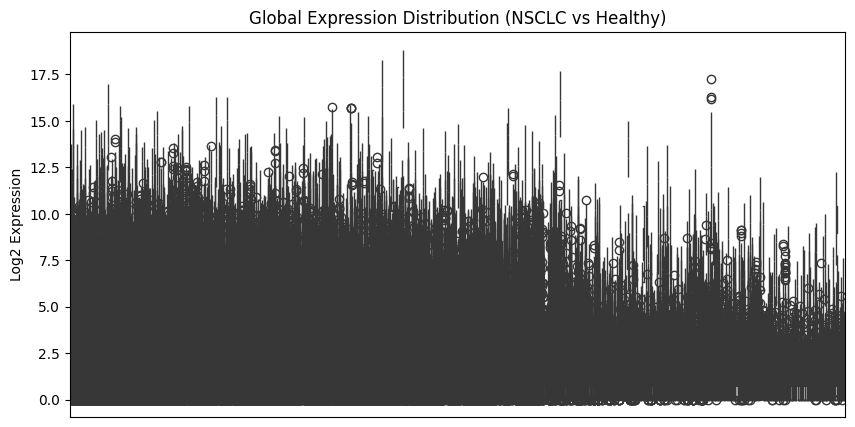

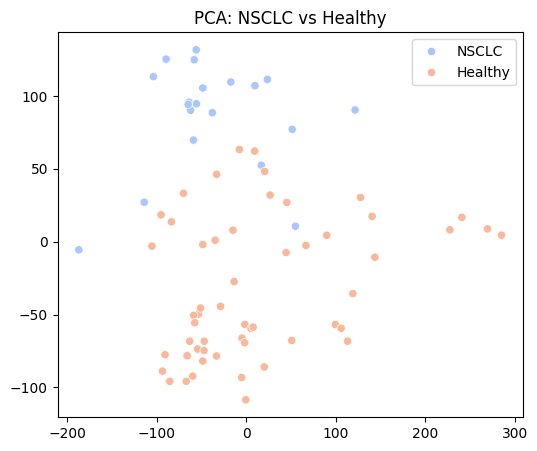

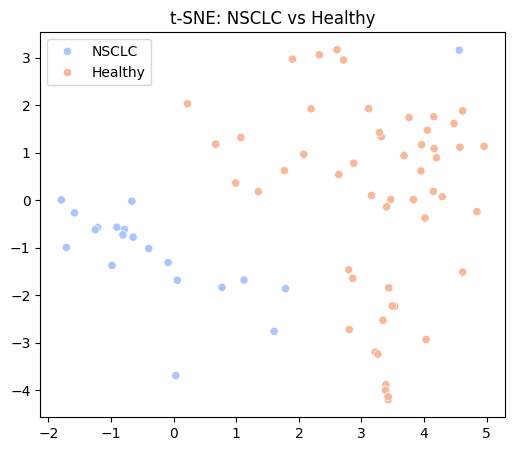

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


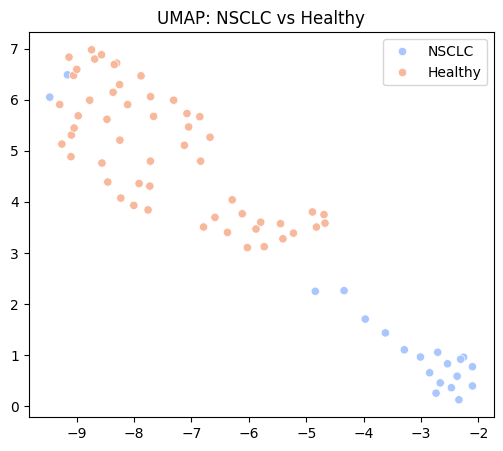

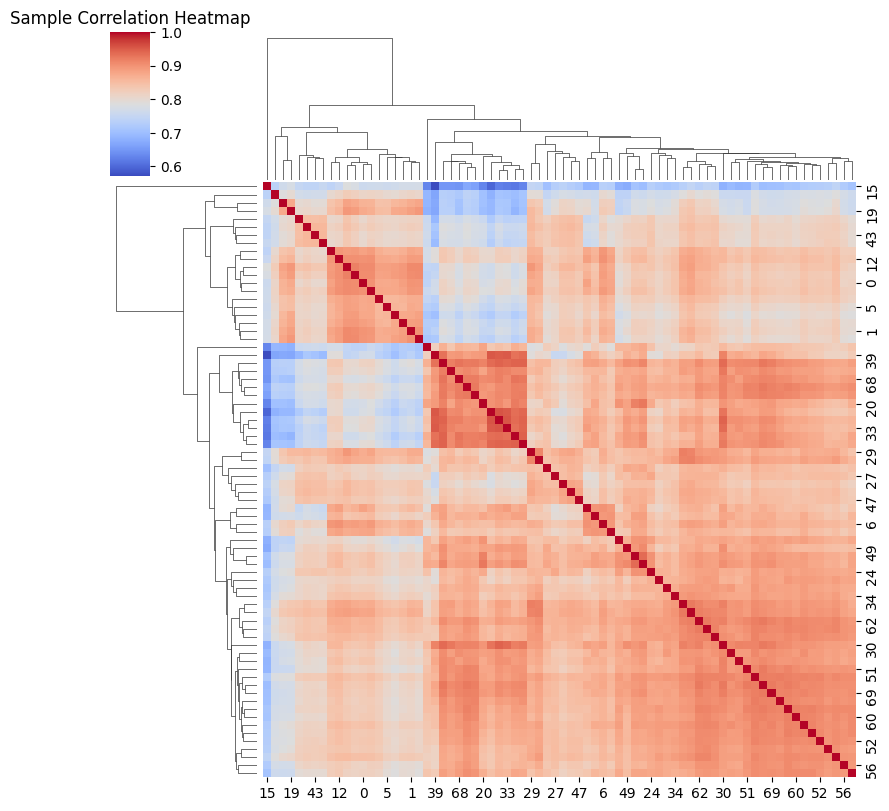

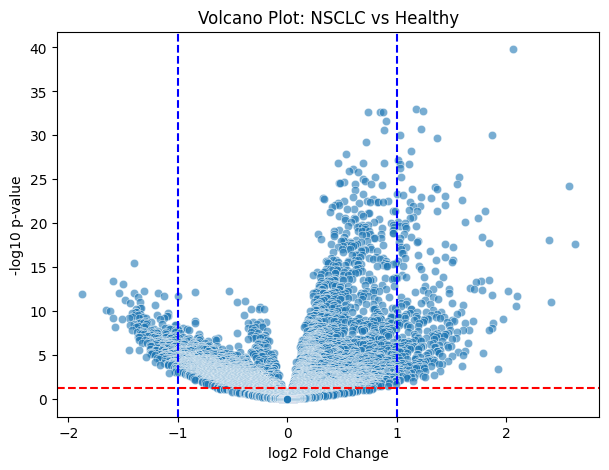

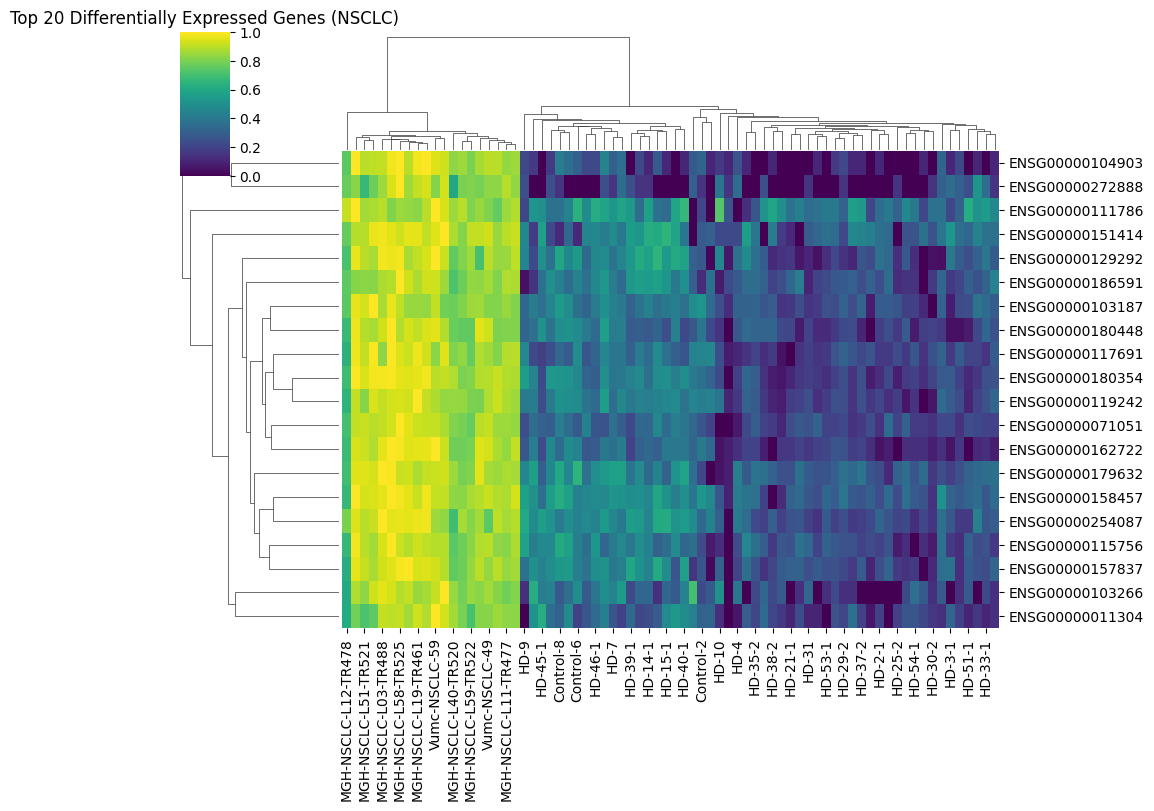

/tmp/ipython-input-219265995.py:128: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Group", y="Expression", data=df, palette="coolwarm")


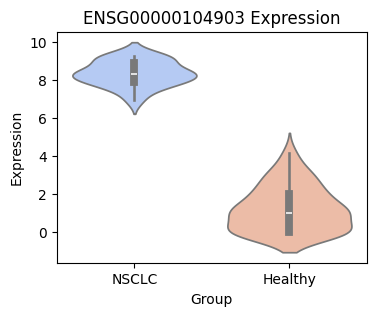

/tmp/ipython-input-219265995.py:128: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Group", y="Expression", data=df, palette="coolwarm")


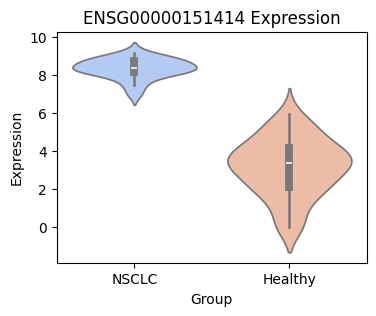

/tmp/ipython-input-219265995.py:128: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Group", y="Expression", data=df, palette="coolwarm")


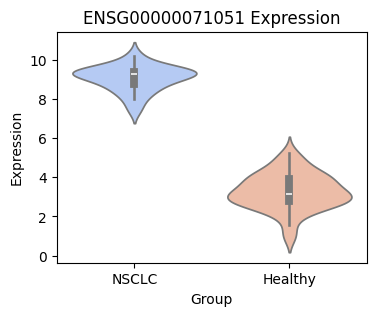

/tmp/ipython-input-219265995.py:128: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Group", y="Expression", data=df, palette="coolwarm")


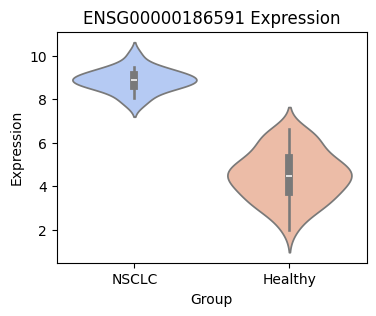

/tmp/ipython-input-219265995.py:128: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Group", y="Expression", data=df, palette="coolwarm")


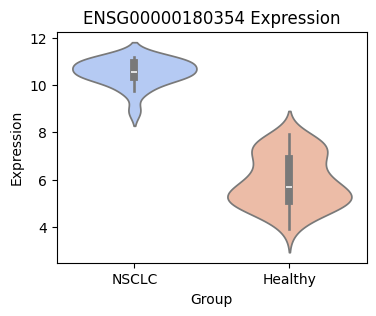

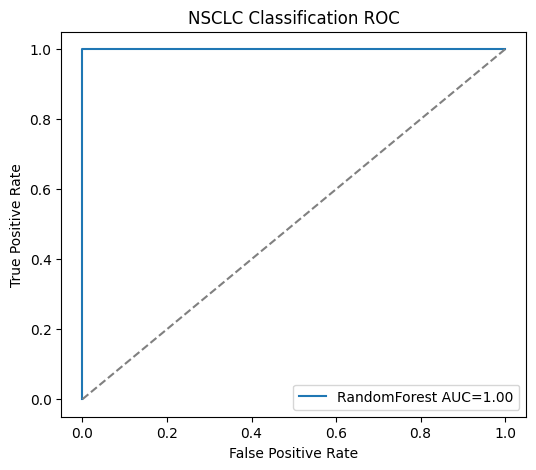

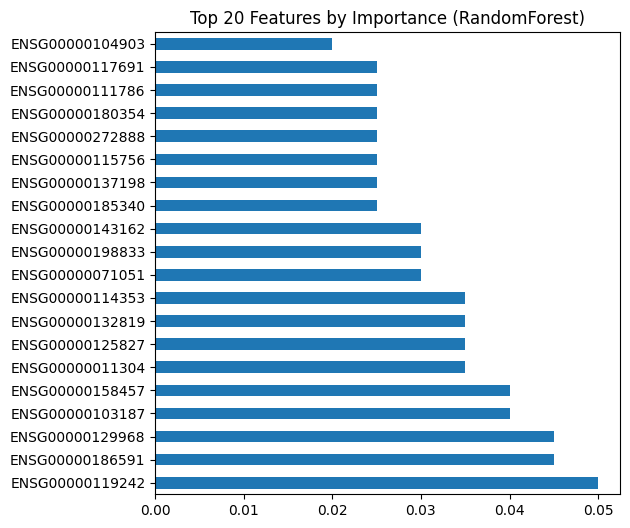

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve

# ---------------------------
# 1. Data Pre-Processing & QC
# ---------------------------

# Load expression matrix (rows=genes, cols=samples)
data = pd.read_csv("/content/GSE68086_TEP_data_matrix.csv", index_col=0)

# Identify NSCLC and Healthy sample columns
nsclc_cols = [c for c in data.columns if "NSCLC" in c.upper()]
healthy_cols = [c for c in data.columns if "HD" in c.upper() or "CONTROL" in c.upper() or "HEALTHY" in c.upper()]
subset = data[nsclc_cols + healthy_cols].dropna()

# Log2 transform if needed
subset = np.log2(subset + 1)

# Filter low-variance genes (keep top 50%)
gene_var = subset.var(axis=1)
subset = subset.loc[gene_var > np.percentile(gene_var, 50)]

# Labels
y = np.array([1 if "NSCLC" in c.upper() else 0 for c in subset.columns])
labels = ["Healthy" if i==0 else "NSCLC" for i in y]

# ---------------------------
# 2. Exploratory Data Analysis
# ---------------------------

# Expression distribution
plt.figure(figsize=(10,5))
sns.boxplot(data=subset.T, palette="coolwarm")
plt.xticks([], [])
plt.ylabel("Log2 Expression")
plt.title("Global Expression Distribution (NSCLC vs Healthy)")
plt.show()

# PCA
pca = PCA(n_components=2)
pca_res = pca.fit_transform(subset.T)
plt.figure(figsize=(6,5))
sns.scatterplot(x=pca_res[:,0], y=pca_res[:,1], hue=labels, palette="coolwarm")
plt.title("PCA: NSCLC vs Healthy")
plt.show()

# t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_res = tsne.fit_transform(subset.T)
plt.figure(figsize=(6,5))
sns.scatterplot(x=tsne_res[:,0], y=tsne_res[:,1], hue=labels, palette="coolwarm")
plt.title("t-SNE: NSCLC vs Healthy")
plt.show()

# UMAP
reducer = umap.UMAP(random_state=42)
umap_res = reducer.fit_transform(subset.T)
plt.figure(figsize=(6,5))
sns.scatterplot(x=umap_res[:,0], y=umap_res[:,1], hue=labels, palette="coolwarm")
plt.title("UMAP: NSCLC vs Healthy")
plt.show()

# Sample correlation heatmap
corr = np.corrcoef(subset.T)
sns.clustermap(corr, cmap="coolwarm", figsize=(8,8))
plt.title("Sample Correlation Heatmap")
plt.show()

# ---------------------------
# 3. Differential Expression Analysis
# ---------------------------

genes = subset.index
pvals, logfc = [], []

for g in genes:
    grp1 = subset.loc[g, nsclc_cols]
    grp0 = subset.loc[g, healthy_cols]
    stat, p = ttest_ind(grp1, grp0, equal_var=False)
    pvals.append(p)
    logfc.append(np.log2(np.mean(grp1)+1) - np.log2(np.mean(grp0)+1))

de_df = pd.DataFrame({"gene": genes, "logFC": logfc, "pval": pvals})
de_df["-log10p"] = -np.log10(de_df["pval"])
de_df = de_df.sort_values("pval")

# Volcano plot
plt.figure(figsize=(7,5))
sns.scatterplot(data=de_df, x="logFC", y="-log10p", alpha=0.6)
plt.axhline(-np.log10(0.05), ls="--", color="red")
plt.axvline(1, ls="--", color="blue")
plt.axvline(-1, ls="--", color="blue")
plt.xlabel("log2 Fold Change")
plt.ylabel("-log10 p-value")
plt.title("Volcano Plot: NSCLC vs Healthy")
plt.show()

# ---------------------------
# 4. Visualization of Top Genes
# ---------------------------

top_genes = de_df.head(20)["gene"]

# Heatmap of top 20 genes
heatmap_data = subset.loc[top_genes]
sns.clustermap(heatmap_data, cmap="viridis", col_cluster=True, row_cluster=True,
               figsize=(10, 8), standard_scale=0)
plt.title("Top 20 Differentially Expressed Genes (NSCLC)")
plt.show()

# Violin plots for top 5 genes
top5 = top_genes[:5]
for gene in top5:
    df = pd.DataFrame({
        "Expression": subset.loc[gene],
        "Group": ["NSCLC" if "NSCLC" in c.upper() else "Healthy" for c in subset.columns]
    })
    plt.figure(figsize=(4,3))
    sns.violinplot(x="Group", y="Expression", data=df, palette="coolwarm")
    plt.title(f"{gene} Expression")
    plt.show()

# ---------------------------
# 5. Feature Selection & Classification
# ---------------------------

features = subset.loc[de_df.head(50)["gene"]].T
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.3, random_state=42)

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict_proba(X_test)[:,1]

fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"RandomForest AUC={roc_auc:.2f}")
plt.plot([0,1],[0,1],'--',color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.title("NSCLC Classification ROC")
plt.show()

importances = pd.Series(rf.feature_importances_, index=features.columns)
importances.sort_values(ascending=False).head(20).plot(kind='barh', figsize=(6,6))
plt.title("Top 20 Features by Importance (RandomForest)")
plt.show()
